# MP3: Deep Fast Image Recognition

Date: 2021.11.26

Solution author: © 2021 [Muruganantham Jaisankar](jaimuruganantham)  
Template author: © 2021 [Mantas Lukoševičius](https://mantas.info/)

This notebook is part of an individual project for [KTU IF](https://fi.ktu.edu/)  [P176M010 Advanced Machine Learning](https://admissions.ktu.edu/programme/m-software-engineering/#P176M010) class led by [M. Lukoševičius](http://mantas.info/).

You should only eddit this notebook where it is allowed, comment on all of your improvements in markdown cells and in your presentation.

The goal is to train a [pytorch](https://pytorch.org/)-based [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) classifier in under 3 minutes for maximum classification accuracy.

This template is partially based on [this tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). 

The performance will be measured on *Tesla K80* graphics card on Google Colab machines. You should select GPU in Google Colab: *Runtime -> Change runtime type -> Hardware accelerator: GPU*.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np

## Settings

Do not eddit!

On the reproducibility of experiments: https://pytorch.org/docs/stable/notes/randomness.html

In [ ]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 1.0*corrects / batch_size
    return accuracy.item()
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Information on the obtained hardware

In [ ]:
print('Torch version: %s' %torch.__version__)
if torch.cuda.is_available():
    print('GPU: %s' %torch.cuda.get_device_name()) 
else:
    print('GPU not available.')

Torch version: 1.10.0+cu111
GPU: Tesla K80


In [ ]:
!nvidia-smi

Sun Dec  5 20:57:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               63
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Stepping:            0
CPU MHz:             2299.998
BogoMIPS:            4599.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            46080K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs 

## Import the data

You can change the data transformations but not the splitting (40000:10000) between training and validation in this notebook. But you can use a different type of validation with this data in our other codes to find the best model and its hyper-parameters, as long as you don't touch testing data. 

In [ ]:
## transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

## download and load training dataset
# do not change this!
dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, validset = torch.utils.data.random_split(dataset, [40000,10000])

BATCH_SIZE = 32

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

len(trainset), len(validset)

Files already downloaded and verified


(40000, 10000)

### Show a couple of data points

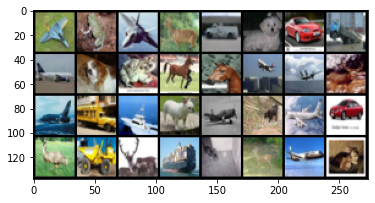

In [ ]:
import matplotlib.pyplot as plt

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

## show images
imshow(torchvision.utils.make_grid(images))

## My models

<span style="color:red">This is the main section which you should rewrite and expand significanlty providing/documenting your models tried and results with them.</span>

They all have to be Pytorch models that solve the CIFAR-10 task.

You can go wild here!

Best methods (code and describing papers) for the dataset can be found here: https://paperswithcode.com/sota/image-classification-on-cifar-10. Note, that most of the solutions are too big and slow for our rules of the game. 

You should probably not base your solutions on the ResNet examples provided here, as they are too slow as well. Remove the unoriginal models form this chapter that you don't investigate. 


### A sample official tutorial model

From https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

I have checked with different channels

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x))) 
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x))) 
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Adoptend from simple MNIST example by "elvis"

Based on https://medium.com/dair-ai/pytorch-1-2-quickstart-with-google-colab-6690a30c38d.

Existing method with different channel

In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)
        self.d1 = nn.Linear(30 * 30 * 64, 128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = x.flatten(start_dim = 1)
        x = self.d1(x)
        x = F.relu(x)
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

### Jai's Models

These Models wokring like Standard Convolutional Neural Netwok

Input image->Convolutional Network Layers->Relu Layers->Maxpool->fully connected layer->output

[Pytorch Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)
and
[Pytorch Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)

In [ ]:
class JaiNet14(nn.Module):
  def __init__(self):
    super(JaiNet14, self).__init__()
    #3x32x32->32x14x14  
    #first con->((32-5)+(2(0)))/1)+1=(27/1)+1=28
    #second max pooling ((28-2)+(2x0))/2)+1=14
    self.layer1 = nn.Sequential(
          nn.Conv2d(3,32, kernel_size=5),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    #32x14x14->64x5x5
    #first con-> (((14-5)+(2x0))/1)+1=10
    #second max pooling -> (10-2)/2+(1)=5
    self.layer2 = nn.Sequential(
          nn.Conv2d(32, 64, kernel_size=5,stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(64* 5 * 5, 120)
    self.fc2 = nn.Linear(120,84) 
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(-1,64*5*5)
    out = self.fc1(out)
    out = self.fc2(out)
    return out

In [ ]:
class JaiNet1(nn.Module):
  def __init__(self):
    super(JaiNet1, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Conv2d(3,32, kernel_size=5),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer2 = nn.Sequential(
          nn.Conv2d(32, 64, kernel_size=5),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(64* 5 * 5, 120)
    self.fc2 = nn.Linear(120,84)
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.reshape(out.size(0), -1)
    out = self.drop_out(out)
    out = self.fc1(out)
    out = self.fc2(out)
    return out

In [ ]:
class JaiNet11(nn.Module):
  def __init__(self):
    super(JaiNet11, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Conv2d(3,32, kernel_size=5),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer2 = nn.Sequential(
          nn.Conv2d(32, 64, kernel_size=5),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(64* 5 * 5, 84)
    self.fc2 = nn.Linear(84,10)
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.reshape(out.size(0), -1)
    out = self.drop_out(out)
    out = self.fc1(out)
    out = self.fc2(out)
    return out

In [ ]:
class JaiNet2(nn.Module):
  def __init__(self):
    super(JaiNet2, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Conv2d(3,10, kernel_size=5),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(10* 30 * 30, 128)
    self.fc2 = nn.Linear(128,10)
  def forward(self, x):
    out = self.layer1(x)
    out = out.reshape(out.size(0), -1)
    out = self.drop_out(out)
    out = self.fc1(out)
    return out

In [ ]:
class JaiNet3(nn.Module):
  def __init__(self):
    super(JaiNet3, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Conv2d(3,10, kernel_size=5),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer2 = nn.Sequential(
          nn.Conv2d(10, 16, kernel_size=5),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(16* 5 * 5, 120)
    self.fc2 = nn.Linear(120,84)
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.reshape(out.size(0), -1)
    out = self.drop_out(out)
    out = self.fc1(out)
    out = self.fc2(out)
    return out

In [ ]:
class JaiNet4(nn.Module):
  def __init__(self):
    super(JaiNet4, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Conv2d(3,32, kernel_size=5),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer2 = nn.Sequential(
          nn.Conv2d(32, 64, kernel_size=5),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(64* 5 * 5, 128)
    self.fc2 = nn.Linear(128,10)
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.reshape(out.size(0), -1)
    out = self.drop_out(out)
    out = self.fc1(out)
    out = self.fc2(out)
    return out

In [ ]:
class JaiNet42(nn.Module):
  def __init__(self):
    super(JaiNet42, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Conv2d(3,32, kernel_size=5),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer2 = nn.Sequential(
          nn.Conv2d(32, 64, kernel_size=5),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(64* 5 * 5, 84)
    self.fc2 = nn.Linear(84,10)
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.reshape(out.size(0), -1)
    out = self.drop_out(out)
    out = self.fc1(out)
    out = self.fc2(out)
    return out

In [ ]:
class JaiNet5(nn.Module):
  def __init__(self):
    super(JaiNet5, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Conv2d(3,64, kernel_size=5),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer2 = nn.Sequential(
          nn.Conv2d(64, 64, kernel_size=5),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(64* 5 * 5, 120)
    self.fc2 = nn.Linear(120,84)
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.reshape(out.size(0), -1)
    out = self.drop_out(out)
    out = self.fc1(out)
    out = self.fc2(out)
    return out

In [ ]:
class JaiNet6(nn.Module):
  def __init__(self):
    super(JaiNet6, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Conv2d(3,64, kernel_size=5),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer2 = nn.Sequential(
          nn.Conv2d(64, 32, kernel_size=5),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(32* 5 * 5, 120)
    self.fc2 = nn.Linear(120,84)
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.reshape(out.size(0), -1)
    out = self.drop_out(out)
    out = self.fc1(out)
    out = self.fc2(out)
    return out

In [ ]:
class JaiNet7(nn.Module):   
    def __init__(self):
        super(JaiNet7, self).__init__()

#3x32x32->64x7x7
        self.cnn_layers = nn.Sequential(
        
            nn.Conv2d(3, 64, kernel_size=3),
            #nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 32, kernel_size=3),
            #nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(32 *  7* 7, 120),
            nn.Linear(120,10)
            )   
    def forward(self, x):
      out = self.cnn_layers(x)
      out = out.reshape(out.size(0), -1)
      out = self.linear_layers(out)
      return out

In [ ]:
class JaiNet8(nn.Module):
  def __init__(self):
    super(JaiNet8, self).__init__()
    #3x32x32->6x14x14  
    #first con->((32-5)+(2(0)))/1)+1=(27/1)+1=28
    #second ((28-2)+(2x0))/2)+1=14
    self.layer1 = nn.Sequential(
          nn.Conv2d(3,6, kernel_size=5),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    #6x14x14->16x5x5
    #first con-> (((14-5)+(2x0))/1)+1=10
    #second max pooling -> (10-2)/2+(1)=5
    self.layer2 = nn.Sequential(
          nn.Conv2d(6, 16, kernel_size=5,stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(16* 5 * 5, 120)
    self.fc2 = nn.Linear(120,84) 
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(-1,16*5*5)
    #out = out.reshape(out.size(0), -1)
    #out = self.drop_out(out)
    out = self.fc1(out)
    out = self.fc2(out)
    return out

In [ ]:
class JaiNet9(nn.Module):
  def __init__(self):
    super(JaiNet9, self).__init__()
    #3x32x32->6x14x14  
    #first con->((32-5)+(2(0)))/1)+1=(27/1)+1=28
    #second ((28-2)+(2x0))/2)+1=14
    self.layer1 = nn.Sequential(
          nn.Conv2d(3,6, kernel_size=5),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    #6x14x14->64x5x5
    #first con-> (((14-5)+(2x0))/1)+1=10
    #second max pooling -> (10-2)/2+(1)=5
    self.layer2 = nn.Sequential(
          nn.Conv2d(6, 64, kernel_size=5,stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    #64x5x5->16x4x4
    self.layer3 = nn.Sequential(
          nn.Conv2d(64, 16, kernel_size=3,stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(64* 5 * 5, 120)
    self.fc2 = nn.Linear(120,84)
    self.fc3= nn.Linear(84,10)
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    #out = self.layer3(out)
    out = out.view(-1,64*5*5)
    #out = out.reshape(out.size(0), -1)
    #out = self.drop_out(out)
    out = self.fc1(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

In [ ]:
class JaiNet10(nn.Module):
  def __init__(self):
    super(JaiNet10, self).__init__()
    #3x32x32->6x15x15  
    #first con->((32-3)+(2(0)))/1)+1=(29/1)+1=30
    #second ((30-2)+(2x0))/2)+1=15
    self.layer1 = nn.Sequential(
          nn.Conv2d(3,6, kernel_size=3),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    #6x15x15->64x5x5
    #first con-> (((15-3)+(2x0))/1)+1=13
    #second max pooling -> (13-2)/2+(1)=6
    self.layer2 = nn.Sequential(
          nn.Conv2d(6, 64, kernel_size=3,stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    #64x5x5->16x4x4
    self.layer3 = nn.Sequential(
          nn.Conv2d(64, 16, kernel_size=3,stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(64* 6 * 6, 120)
    self.fc2 = nn.Linear(120,84)
    self.fc3= nn.Linear(84,10)
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    #out = self.layer3(out)
    out = out.view(-1,64*6*6)
    #out = out.reshape(out.size(0), -1)
    #out = self.drop_out(out)
    out = self.fc1(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

In [ ]:
class JaiNet111(nn.Module):
  def __init__(self):
    super(JaiNet111, self).__init__()
    #3x32x32->6x15x15  
    #first con->((32-3)+(2(0)))/1)+1=(29/1)+1=30
    #second ((30-2)+(2x0))/2)+1=15
    self.layer1 = nn.Sequential(
          nn.Conv2d(3,6, kernel_size=3),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    #6x15x15->64x5x5
    #first con-> (((15-3)+(2x0))/1)+1=13
    #second max pooling -> (13-2)/2+(1)=6
    self.layer2 = nn.Sequential(
          nn.Conv2d(6, 64, kernel_size=3,stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    #64x5x5->16x4x4
    self.layer3 = nn.Sequential(
          nn.Conv2d(64, 16, kernel_size=3,stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(64* 6 * 6, 120)
    self.fc2 = nn.Linear(120,84)
    self.fc3= nn.Linear(84,10)
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    #out = self.layer3(out)
    out = out.view(-1,64*6*6)
    #out = out.reshape(out.size(0), -1)
    #out = self.drop_out(out)
    out = self.fc1(out)
    out = self.fc2(out)
    #out = self.fc3(out)
    return out

In [ ]:
class JaiNet12(nn.Module):
  def __init__(self):
    super(JaiNet12, self).__init__()
    #3x32x32->6x15x15  
    #first con->((32-3)+(2(0)))/1)+1=(29/1)+1=30
    #second ((30-2)+(2x0))/2)+1=15
    self.layer1 = nn.Sequential(
          nn.Conv2d(3,6, kernel_size=3),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    #6x15x15->64x5x5
    #first con-> (((15-3)+(2x0))/1)+1=13
    #second max pooling -> (13-2)/2+(1)=6
    self.layer2 = nn.Sequential(
          nn.Conv2d(6, 64, kernel_size=3,stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    #64x5x5->16x4x4
    self.layer3 = nn.Sequential(
          nn.Conv2d(64, 16, kernel_size=3,stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(64* 6 * 6, 120)
    self.fc2 = nn.Linear(120,84)
    self.fc3= nn.Linear(84,5)
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(-1,64*6*6)
    #out = self.drop_out(out)
    out = self.fc1(out)
    out = self.fc2(out)
    return out

In [ ]:
class JaiNet13(nn.Module):
  def __init__(self):
    super(JaiNet13, self).__init__()
    #3x32x32->6x7x7  
    #first con->((32-6)+(2(0)))/2)+1=(26/2)+1=14
    #second ((14-2)+(2x0))/2)+1=7
    self.layer1 = nn.Sequential(
          nn.Conv2d(3,6, kernel_size=6,stride=2),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    #6x7x7->64x5x5
    #first con-> (((7-6)+(2x0))/1)+1=2
    #second max pooling -> (2-2)/2+(1)=1
    self.layer2 = nn.Sequential(
          nn.Conv2d(6, 64, kernel_size=6,stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    #64x5x5->16x4x4
    self.layer3 = nn.Sequential(
          nn.Conv2d(64, 16, kernel_size=3,stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(64* 1 * 1, 120)
    self.fc2 = nn.Linear(120,84)
    self.fc3= nn.Linear(84,5)
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    #out = self.layer3(out)
    #out = out.view(-1,64*1*1)
    out = out.reshape(out.size(0), -1)
    #out = self.drop_out(out)
    out = self.fc1(out)
    out = self.fc2(out)
    #out = self.fc3(out)
    return out

In [ ]:
class JaiNet15(nn.Module):
  def __init__(self):
    super(JaiNet15, self).__init__()
    #3x32x32->6x28x28  
    #first con->((32-5)+(2(0)))/2)+1=(27/2)+1=14
    #second ((14-2)+(2x0))/2)+1=7
    self.layer1 = nn.Sequential(
          nn.Conv2d(3,32, kernel_size=5,stride=2),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    #32x7x7->64x5x5
    #first con-> (((7-5)+(2x0))/1)+1=3
    #second max pooling -> (3-2)/2+(1)=2
    self.layer2 = nn.Sequential(
          nn.Conv2d(32, 64, kernel_size=5,stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=1))
    self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(64* 2 * 2, 120)
    self.fc2 = nn.Linear(120,84) 
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(-1,64*2*2)
    #out = out.reshape(out.size(0), -1)
    #out = self.drop_out(out)
    out = self.fc1(out)
    out = self.fc2(out)
    return out

In [ ]:
class JaiNet16(nn.Module):
  def __init__(self):
    super(JaiNet16, self).__init__()
    #3x32x32->6x28x28  
    #first con->((32-3)+(2(0)))/2)+1=(29/2)+1=15
    #second ((15-2)+(2x0))/2)+1=7
    self.layer1 = nn.Sequential(
          nn.Conv2d(3,32, kernel_size=3,stride=2),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    #32x7x7->64x5x5
    #first con-> (((7-5)+(2x0))/1)+1=3
    #second max pooling -> (3-2)/2+(1)=2
    self.layer2 = nn.Sequential(
          nn.Conv2d(32, 64, kernel_size=5,stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=1))
    self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(64* 2 * 2, 120)
    self.fc2 = nn.Linear(120,84) 
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(-1,64*2*2)
    #out = out.reshape(out.size(0), -1)
    #out = self.drop_out(out)
    out = self.fc1(out)
    out = self.fc2(out)
    return out

## Learning parameters

You have a freedom here. The `num_epochs` should be such that training should not exceed 3 minutes on Tesla K80. Different parameters can be tried on different models. Results reported above.

But the final version for training `my_best_model` should be left when submitting the notebook, because it's training time and testing performance will be evaluated. 

In [ ]:
BATCH_SIZE = 32

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

learning_rate = 0.001
num_epochs = 10 #16

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_best_model = JaiNet14()#ResNet12() #Net3() # ResNet18()#ConvNet() 
my_best_model = my_best_model.to(device)
# my_best_model = torch.nn.DataParallel(my_best_model) # make parallel
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_best_model.parameters(), lr=learning_rate)
scaler = torch.cuda.amp.GradScaler()

## Report of the things tried and their validation results


The results can be:

| Model | Epochs | Training time, s | Training accuracy | Validation accuracy |
|-------|--------|------------------|-------------------|---------------------|
| JaiNet1|   11    | 178             |  0.65             | 0.67                |
| JaiNet11|   10    | 163             |  0.62             | 0.66                |
| JaiNet3|   11    | 170             |  0.53             | 0.58                |
| JaiNet4|   11    | 178             |  0.66             | 0.69                |
| JaiNet42|   11    | 178             |  0.64             | 0.64               |
| JaiNet5|   10    | 173             |  0.64             | 0.66                |
| JaiNet6|   9    | 163             |  0.57             | 0.63                |
| JaiNet8|   11    | 171             |  0.59             | 0.57                |
| JaiNet9|   11    | 179.8             |  0.68             | 0.60                |
| JaiNet10|   11    | 163             |  0.74             | 0.62                |
| JaiNet111|   11    | 162             |  0.73             | 0.62                |
| JaiNet12|   10    | 165             |  0.75             | 0.63                |
| JaiNet14|   11    | 178             |  0.74             | 0.67                |
| JaiNet15|   11    | 178             |  0.69             | 0.63                |
| JaiNet15|   11    | 178             |  0.68            | 0.61               |





JaiNet14 model have the best result with Training Accuracy as .74 and Validation accuracy as .67. I would suggest you to check multiple times so that we can know the best Accuracy. 

## Train

<span style="color:red">Do not edit beyound this point!</span>

The training is only happening here. The same training (without your modifications if any) will be done to evaluate your `my_best_model`. 

In [ ]:
# timing. do not alter!
start_timer = torch.cuda.Event(enable_timing=True)
end_timer = torch.cuda.Event(enable_timing=True)
start_timer.record()

# training stats
trainlosses = np.zeros(num_epochs)
trainaccs = np.zeros(num_epochs)
validaccs = np.zeros(num_epochs)

for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    my_best_model = my_best_model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        with torch.cuda.amp.autocast():
            logits = my_best_model(images)
            loss = criterion(logits, labels)
        optimizer.zero_grad()
        # loss.backward()
        scaler.scale(loss).backward()

        ## update model params
        #optimizer.step()
        scaler.step(optimizer)
        scaler.update()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    my_best_model.eval()
    train_running_loss /= len(trainloader)
    train_acc /= len(trainloader)

    valid_acc = 0.0
    for i, (images, labels) in enumerate(validloader, 0):
        images = images.to(device)
        labels = labels.to(device)
        outputs = my_best_model(images)
        valid_acc += get_accuracy(outputs, labels, BATCH_SIZE)
    
    valid_acc /= len(validloader)

    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.4f | Validation Accuracy: %.4f' \
          %(epoch, train_running_loss, train_acc, valid_acc)) 
            
    trainlosses[epoch] = train_running_loss
    trainaccs[epoch] = train_acc
    validaccs[epoch] = valid_acc

# timing. do not alter!
end_timer.record()
torch.cuda.synchronize()
elapsed_time = start_timer.elapsed_time(end_timer)
max_training_time = 3*60*1000
print('Training time: %.2f ms (max %i ms.)' %(elapsed_time,max_training_time))  
assert elapsed_time <= max_training_time, 'Training is too long!'

Epoch: 0 | Loss: 1.5857 | Train Accuracy: 0.4280 | Validation Accuracy: 0.4829
Epoch: 1 | Loss: 1.2228 | Train Accuracy: 0.5700 | Validation Accuracy: 0.5787
Epoch: 2 | Loss: 1.0898 | Train Accuracy: 0.6203 | Validation Accuracy: 0.6125
Epoch: 3 | Loss: 1.0116 | Train Accuracy: 0.6462 | Validation Accuracy: 0.6166
Epoch: 4 | Loss: 0.9463 | Train Accuracy: 0.6693 | Validation Accuracy: 0.6535
Epoch: 5 | Loss: 0.8970 | Train Accuracy: 0.6893 | Validation Accuracy: 0.6541
Epoch: 6 | Loss: 0.8570 | Train Accuracy: 0.7017 | Validation Accuracy: 0.6640
Epoch: 7 | Loss: 0.8198 | Train Accuracy: 0.7159 | Validation Accuracy: 0.6503
Epoch: 8 | Loss: 0.7863 | Train Accuracy: 0.7256 | Validation Accuracy: 0.6668
Epoch: 9 | Loss: 0.7577 | Train Accuracy: 0.7356 | Validation Accuracy: 0.6651
Training time: 164933.39 ms (max 180000 ms.)


Plot training loss, training and validation accuracy over training epochs.

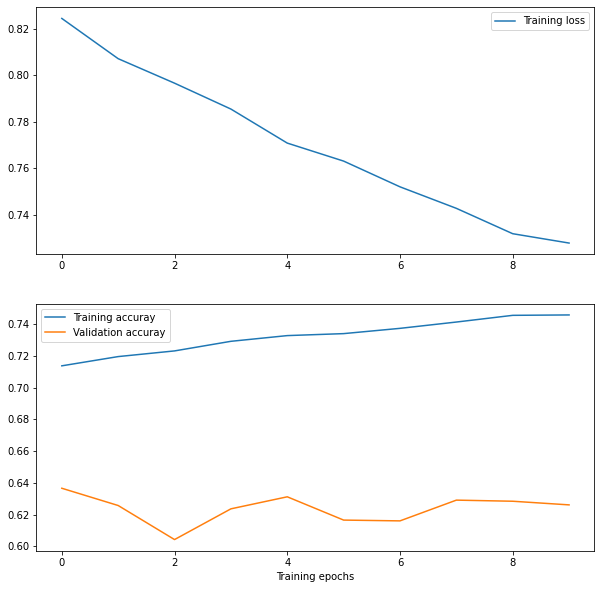

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(trainlosses)
plt.legend(['Training loss']) 
plt.subplot(2,1,2)
plt.plot(trainaccs)
plt.plot(validaccs)
plt.xlabel('Training epochs')
plt.legend(['Training accuray','Validation accuray'])

## Testing of my_best_model will be done here

Validation (once again) of the trained model is put here as placeholder (should work!), will be replaced with testing.

In [ ]:
valid_acc = 0.0
for i, (images, labels) in enumerate(validloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = my_best_model(images)
    valid_acc += get_accuracy(outputs, labels, BATCH_SIZE)

valid_acc /= len(validloader)

print('Validation Accuracy: %.4f' %(valid_acc)) 

Validation Accuracy: 0.6651
